# Benchmark EDA: timing-oracle vs. Other Timing Analysis Tools

**Purpose:** Exploratory Data Analysis of overnight and fine-threshold benchmark results.

**Key Questions:**
1. What is the False Positive Rate (FPR) for each tool at effect=0?
2. How do power curves compare across tools?
3. How does autocorrelation affect detection rates?
4. Which effect patterns are hardest to detect?
5. What are the execution time trade-offs?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Import local utilities
from benchmark_utils import (
    load_overnight_data, load_fine_threshold_data,
    compute_fpr, compute_detection_rate, compute_power_by_effect,
    filter_primary_tools, wilson_ci,
    create_effect_autocorr_matrix,
    COLORBLIND_PALETTE, TOOL_DISPLAY_NAMES, PRIMARY_TOOLS,
    get_tool_color, get_tool_display_name, format_percent
)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# Use colorblind-safe style
sns.set_palette(list(COLORBLIND_PALETTE.values()))

warnings.filterwarnings('ignore', category=FutureWarning)

# Output directory for figures (in analysis directory)
ANALYSIS_DIR = Path(__file__).parent if '__file__' in dir() else Path('.')
FIGURES_DIR = ANALYSIS_DIR / 'figures'
FIGURES_DIR.mkdir(exist_ok=True)

print("Setup complete.")

Setup complete.


## 1. Load and Explore Data

In [2]:
# Load both datasets
overnight_df = load_overnight_data()
fine_df = load_fine_threshold_data()

print(f"Overnight data: {len(overnight_df):,} rows")
print(f"Fine-threshold data: {len(fine_df):,} rows")
print()

# Basic info
print("Overnight dataset:")
print(f"  Tools: {overnight_df['tool'].nunique()} ({', '.join(overnight_df['tool'].unique())})")
print(f"  Effect patterns: {overnight_df['effect_pattern'].nunique()} ({', '.join(overnight_df['effect_pattern'].unique())})")
print(f"  Effect sizes: {sorted(overnight_df['effect_sigma_mult'].unique())}")
print(f"  Noise models: {overnight_df['noise_model'].nunique()}")
print()

print("Fine-threshold dataset:")
print(f"  Tools: {fine_df['tool'].nunique()} ({', '.join(fine_df['tool'].unique())})")
print(f"  Effect patterns: {fine_df['effect_pattern'].nunique()} ({', '.join(fine_df['effect_pattern'].unique())})")
print(f"  Effect sizes: {sorted(fine_df['effect_sigma_mult'].unique())}")
print(f"  Autocorr range: [{fine_df['autocorr'].min()}, {fine_df['autocorr'].max()}]")

Overnight data: 100,800 rows
Fine-threshold data: 48,600 rows

Overnight dataset:
  Tools: 6 (timing-oracle, dudect, timing-tvla, ks-test, ad-test, mona)
  Effect patterns: 6 (null, shift, tail, variance, bimodal, quantized)
  Effect sizes: [np.float64(0.0), np.float64(1e-05), np.float64(0.0001), np.float64(0.001), np.float64(0.01), np.float64(0.1), np.float64(1.0)]
  Noise models: 4

Fine-threshold dataset:
  Tools: 9 (timing-oracle, dudect, timing-tvla, ks-test, ad-test, mona, rtlf-native, silent, tlsfuzzer)
  Effect patterns: 1 (shift)
  Effect sizes: [np.float64(0.0), np.float64(0.0001), np.float64(0.0002), np.float64(0.0004), np.float64(0.0006), np.float64(0.0008), np.float64(0.001), np.float64(0.0012), np.float64(0.0015), np.float64(0.002), np.float64(0.003), np.float64(0.005)]
  Autocorr range: [-0.8, 0.8]


In [3]:
# Preview data structure
overnight_df.head(10)

,tool,preset,effect_pattern,effect_sigma_mult,noise_model,dataset_id,samples_per_class,detected,statistic,p_value,time_ms,samples_used,autocorr
0,timing-oracle,thorough,null,0.0,iid-realistic,0,20000,False,0.0,NaN,267,20000,0.0
1,dudect,thorough,null,0.0,iid-realistic,0,20000,True,NaN,NaN,21,37465,0.0
2,timing-tvla,thorough,null,0.0,iid-realistic,0,20000,True,NaN,NaN,0,40000,0.0
3,ks-test,thorough,null,0.0,iid-realistic,0,20000,True,1.0,NaN,1,40000,0.0
4,ad-test,thorough,null,0.0,iid-realistic,0,20000,True,1.0,NaN,1,40000,0.0
5,mona,thorough,null,0.0,iid-realistic,0,20000,True,NaN,NaN,0,40000,0.0
6,timing-oracle,thorough,null,0.0,iid-realistic,1,20000,False,0.0,NaN,270,20000,0.0
7,dudect,thorough,null,0.0,iid-realistic,1,20000,True,NaN,NaN,22,37744,0.0
8,timing-tvla,thorough,null,0.0,iid-realistic,1,20000,False,NaN,NaN,0,40000,0.0
9,ks-test,thorough,null,0.0,iid-realistic,1,20000,True,1.0,NaN,1,40000,0.0


## 2. False Positive Rate Comparison (Critical)

**Key finding:** timing-oracle achieves 0% FPR where others have catastrophic FPR (94-100%).

In [4]:
# Compute FPR for overnight data (effect=0)
overnight_fpr = compute_fpr(overnight_df)
overnight_fpr = overnight_fpr.sort_values('detection_rate')

# Display table
fpr_table = overnight_fpr.copy()
fpr_table['FPR'] = fpr_table['detection_rate'].apply(lambda x: format_percent(x, 1))
fpr_table['95% CI'] = fpr_table.apply(lambda r: f"[{format_percent(r['ci_low'], 1)}, {format_percent(r['ci_high'], 1)}]", axis=1)
fpr_table['Tool'] = fpr_table['tool'].apply(get_tool_display_name)
print("False Positive Rate at effect=0 (Overnight Dataset):")
print(fpr_table[['Tool', 'FPR', '95% CI', 'n_trials']].to_string(index=False))

False Positive Rate at effect=0 (Overnight Dataset):
         Tool    FPR          95% CI  n_trials
timing-oracle   0.0%    [0.0%, 0.2%]    2400.0
         TVLA  94.5%  [93.5%, 95.3%]    2400.0
       dudect 100.0% [99.8%, 100.0%]    2400.0
      AD-test 100.0% [99.8%, 100.0%]    2400.0
      KS-test 100.0% [99.8%, 100.0%]    2400.0
         MONA 100.0% [99.8%, 100.0%]    2400.0


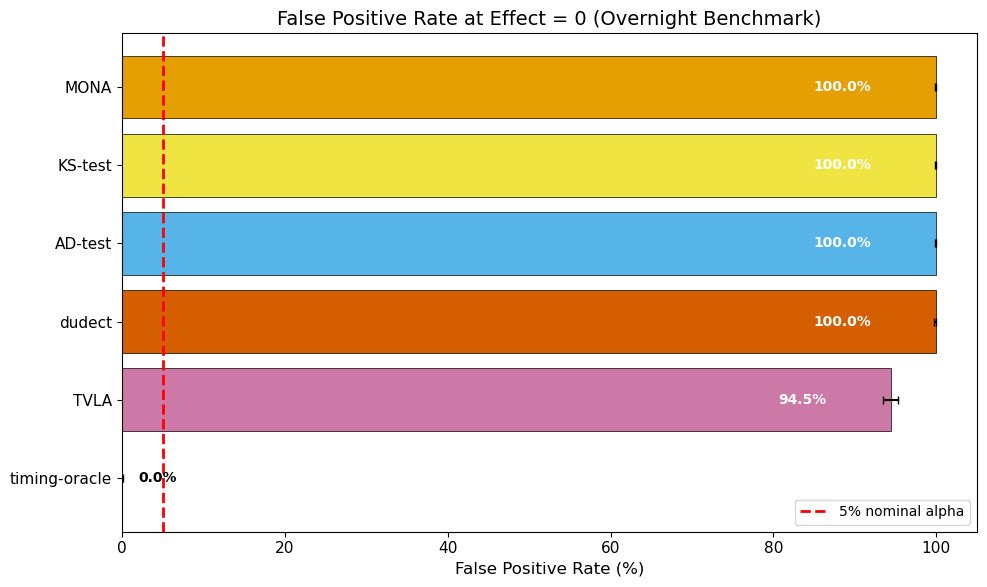

Saved: figures/fpr_comparison.png


In [5]:
# FPR Horizontal Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
fpr_data = overnight_fpr.copy()
fpr_data['display_name'] = fpr_data['tool'].apply(get_tool_display_name)
fpr_data = fpr_data.sort_values('detection_rate', ascending=True)

# Colors for each tool
colors = [get_tool_color(t) for t in fpr_data['tool']]

# Plot horizontal bars
y_pos = np.arange(len(fpr_data))
bars = ax.barh(y_pos, fpr_data['detection_rate'] * 100, color=colors, edgecolor='black', linewidth=0.5)

# Error bars (CI) - ensure non-negative
xerr_low = np.maximum(0, (fpr_data['detection_rate'] - fpr_data['ci_low']) * 100).values
xerr_high = np.maximum(0, (fpr_data['ci_high'] - fpr_data['detection_rate']) * 100).values
ax.errorbar(fpr_data['detection_rate'].values * 100, y_pos, xerr=[xerr_low, xerr_high], 
            fmt='none', color='black', capsize=3, capthick=1)

# 5% reference line
ax.axvline(x=5, color='red', linestyle='--', linewidth=2, label='5% nominal alpha')

# Labels
ax.set_yticks(y_pos)
ax.set_yticklabels(fpr_data['display_name'])
ax.set_xlabel('False Positive Rate (%)')
ax.set_title('False Positive Rate at Effect = 0 (Overnight Benchmark)')
ax.set_xlim(0, 105)
ax.legend(loc='lower right')

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, fpr_data['detection_rate'])):
    label = f'{rate*100:.1f}%'
    x_pos = bar.get_width() + 2
    if x_pos > 95:
        x_pos = bar.get_width() - 8
        ax.text(x_pos, i, label, va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:
        ax.text(x_pos, i, label, va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fpr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fpr_comparison.png'}")

## 3. Power Curves by Tool

Detection rate vs effect size for each tool.

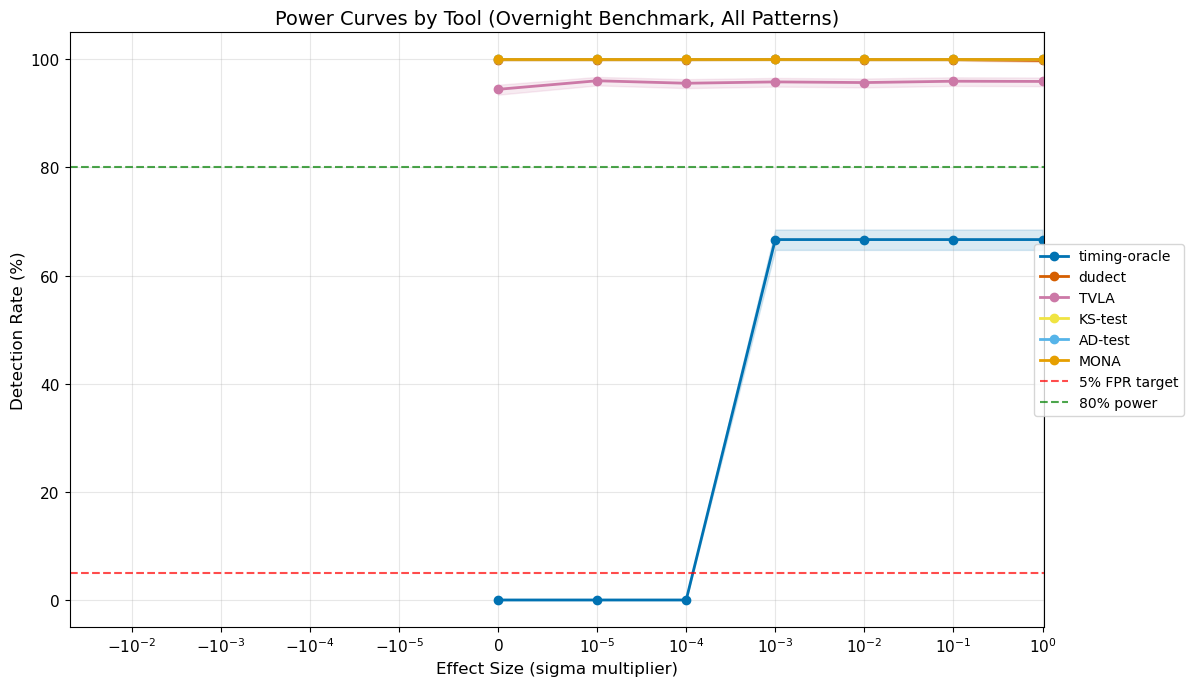

Saved: figures/power_curves_overnight.png


In [6]:
# Compute power curves for overnight data (all patterns)
overnight_power = compute_power_by_effect(overnight_df)

# Filter to primary tools
overnight_power_primary = overnight_power[overnight_power['tool'].isin(PRIMARY_TOOLS)]

# Plot power curves
fig, ax = plt.subplots(figsize=(12, 7))

for tool in PRIMARY_TOOLS:
    tool_data = overnight_power_primary[overnight_power_primary['tool'] == tool]
    if len(tool_data) == 0:
        continue
    
    tool_data = tool_data.sort_values('effect_sigma_mult')
    x = tool_data['effect_sigma_mult']
    y = tool_data['detection_rate'] * 100
    ci_low = tool_data['ci_low'] * 100
    ci_high = tool_data['ci_high'] * 100
    
    color = get_tool_color(tool)
    label = get_tool_display_name(tool)
    
    ax.plot(x, y, 'o-', color=color, label=label, linewidth=2, markersize=6)
    ax.fill_between(x, ci_low, ci_high, color=color, alpha=0.15)

# Reference lines
ax.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='5% FPR target')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% power')

ax.set_xlabel('Effect Size (sigma multiplier)')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Power Curves by Tool (Overnight Benchmark, All Patterns)')
ax.set_xscale('symlog', linthresh=1e-5)
ax.set_ylim(-5, 105)
ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'power_curves_overnight.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'power_curves_overnight.png'}")

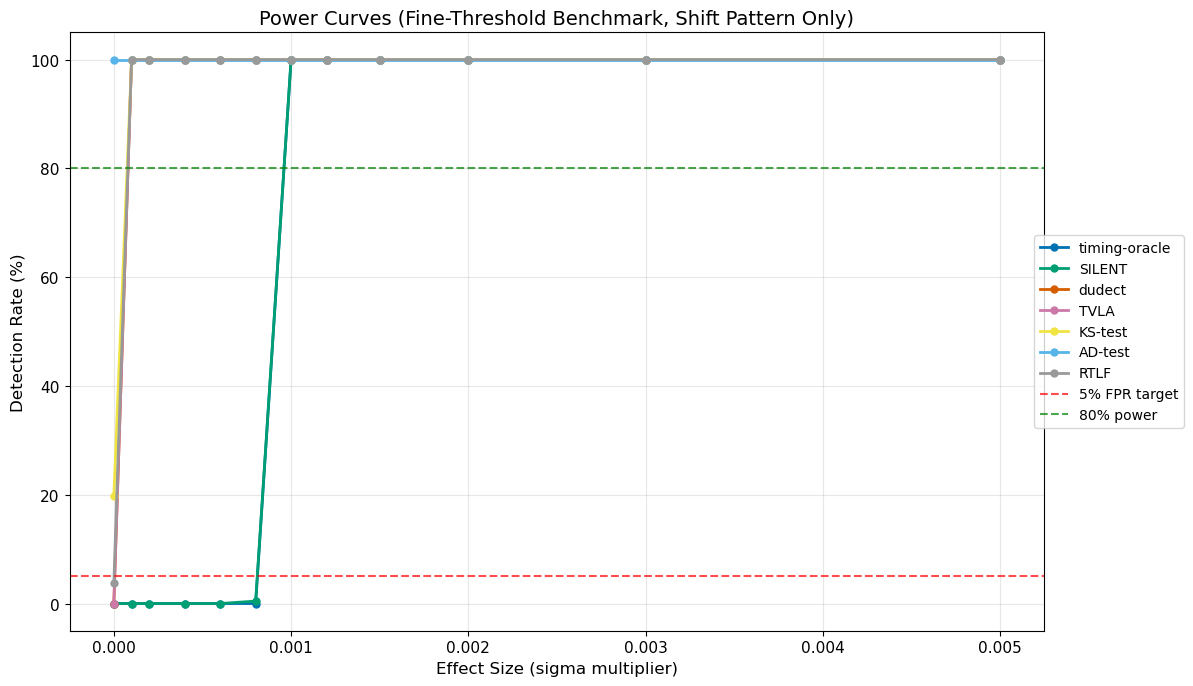

Saved: figures/power_curves_fine.png


In [7]:
# Fine-threshold power curves (more detailed near threshold)
fine_power = compute_power_by_effect(fine_df)

# Filter to tools with meaningful data (exclude tlsfuzzer which has 0% everywhere)
fine_tools = ['timing-oracle', 'silent', 'dudect', 'timing-tvla', 'ks-test', 'ad-test', 'rtlf-native']
fine_power_filtered = fine_power[fine_power['tool'].isin(fine_tools)]

fig, ax = plt.subplots(figsize=(12, 7))

for tool in fine_tools:
    tool_data = fine_power_filtered[fine_power_filtered['tool'] == tool]
    if len(tool_data) == 0:
        continue
    
    tool_data = tool_data.sort_values('effect_sigma_mult')
    x = tool_data['effect_sigma_mult']
    y = tool_data['detection_rate'] * 100
    
    color = get_tool_color(tool)
    label = get_tool_display_name(tool)
    
    ax.plot(x, y, 'o-', color=color, label=label, linewidth=2, markersize=5)

ax.axhline(y=5, color='red', linestyle='--', alpha=0.7, label='5% FPR target')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='80% power')

ax.set_xlabel('Effect Size (sigma multiplier)')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Power Curves (Fine-Threshold Benchmark, Shift Pattern Only)')
ax.set_ylim(-5, 105)
ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'power_curves_fine.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'power_curves_fine.png'}")

## 4. Autocorrelation x Effect Size Heatmaps

How does autocorrelation affect detection rates at different effect sizes?

In [8]:
from matplotlib.colors import LinearSegmentedColormap

# Custom diverging colormap: white at 0%, blue at 100%
heatmap_cmap = LinearSegmentedColormap.from_list(
    'detection', 
    [(1, 1, 1), (0.85, 0.85, 0.95), (0.2, 0.4, 0.8), (0, 0.2, 0.6)],
    N=256
)

def plot_autocorr_heatmap(df, tool, ax, title=None):
    """Plot autocorrelation x effect size heatmap for a single tool."""
    matrix, effect_vals, autocorr_vals = create_effect_autocorr_matrix(df, tool, 'detected')
    
    # Plot heatmap
    im = ax.imshow(matrix * 100, cmap=heatmap_cmap, aspect='auto', 
                   vmin=0, vmax=100, origin='lower')
    
    # Add cell annotations
    for i in range(len(autocorr_vals)):
        for j in range(len(effect_vals)):
            val = matrix[i, j] * 100
            if not np.isnan(val):
                text_color = 'white' if val > 60 else 'black'
                ax.text(j, i, f'{val:.0f}', ha='center', va='center', 
                       fontsize=8, color=text_color, fontweight='bold')
    
    # Axis labels
    ax.set_xticks(range(len(effect_vals)))
    ax.set_xticklabels([f'{e:.4f}' if e < 0.001 else f'{e:.3f}' for e in effect_vals], 
                       rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(autocorr_vals)))
    ax.set_yticklabels([f'{a:.1f}' for a in autocorr_vals], fontsize=9)
    ax.set_xlabel('Effect Size (sigma mult)', fontsize=10)
    ax.set_ylabel('Autocorrelation (phi)', fontsize=10)
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return im

/private/tmp/nix-shell-72060-460946160/ipykernel_72186/1920944963.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


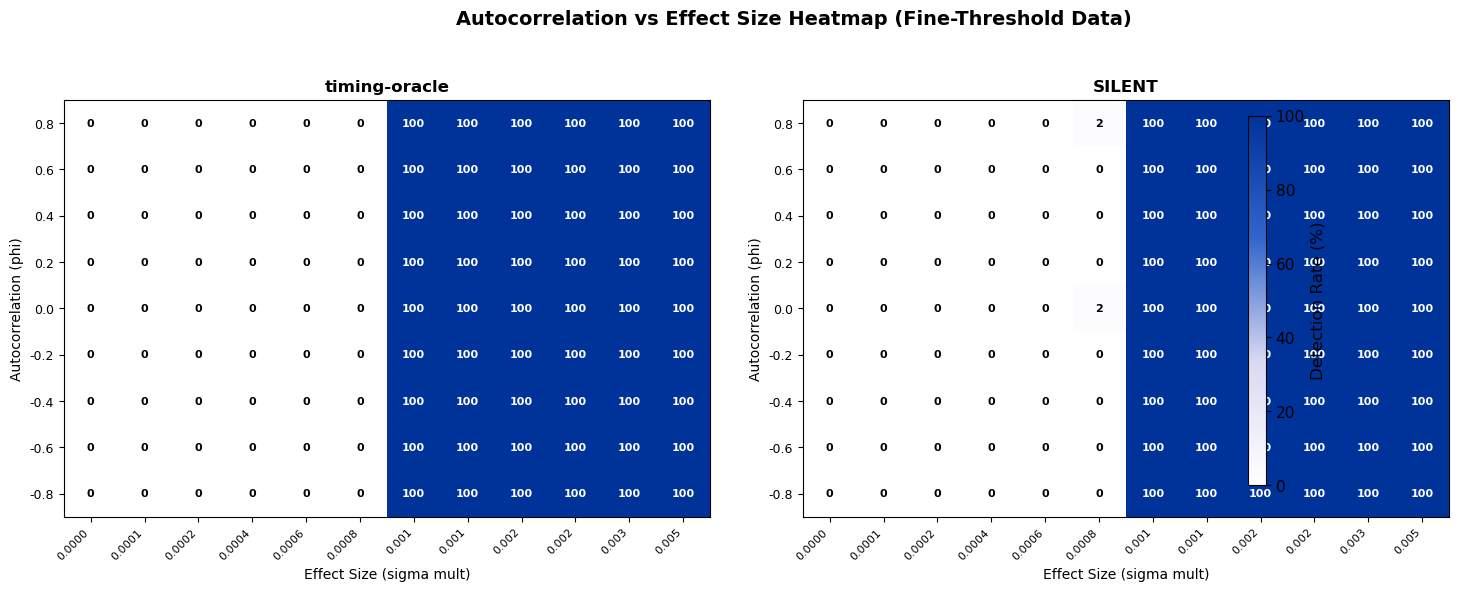

Saved: figures/autocorr_heatmap_oracle_silent.png


In [9]:
# Compare timing-oracle vs silent (the two production-ready tools)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im1 = plot_autocorr_heatmap(fine_df, 'timing-oracle', axes[0], 'timing-oracle')
im2 = plot_autocorr_heatmap(fine_df, 'silent', axes[1], 'SILENT')

# Shared colorbar
fig.colorbar(im2, ax=axes, label='Detection Rate (%)', shrink=0.8)

fig.suptitle('Autocorrelation vs Effect Size Heatmap (Fine-Threshold Data)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.savefig(FIGURES_DIR / 'autocorr_heatmap_oracle_silent.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'autocorr_heatmap_oracle_silent.png'}")

/private/tmp/nix-shell-72060-460946160/ipykernel_72186/3367711405.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 0.96])


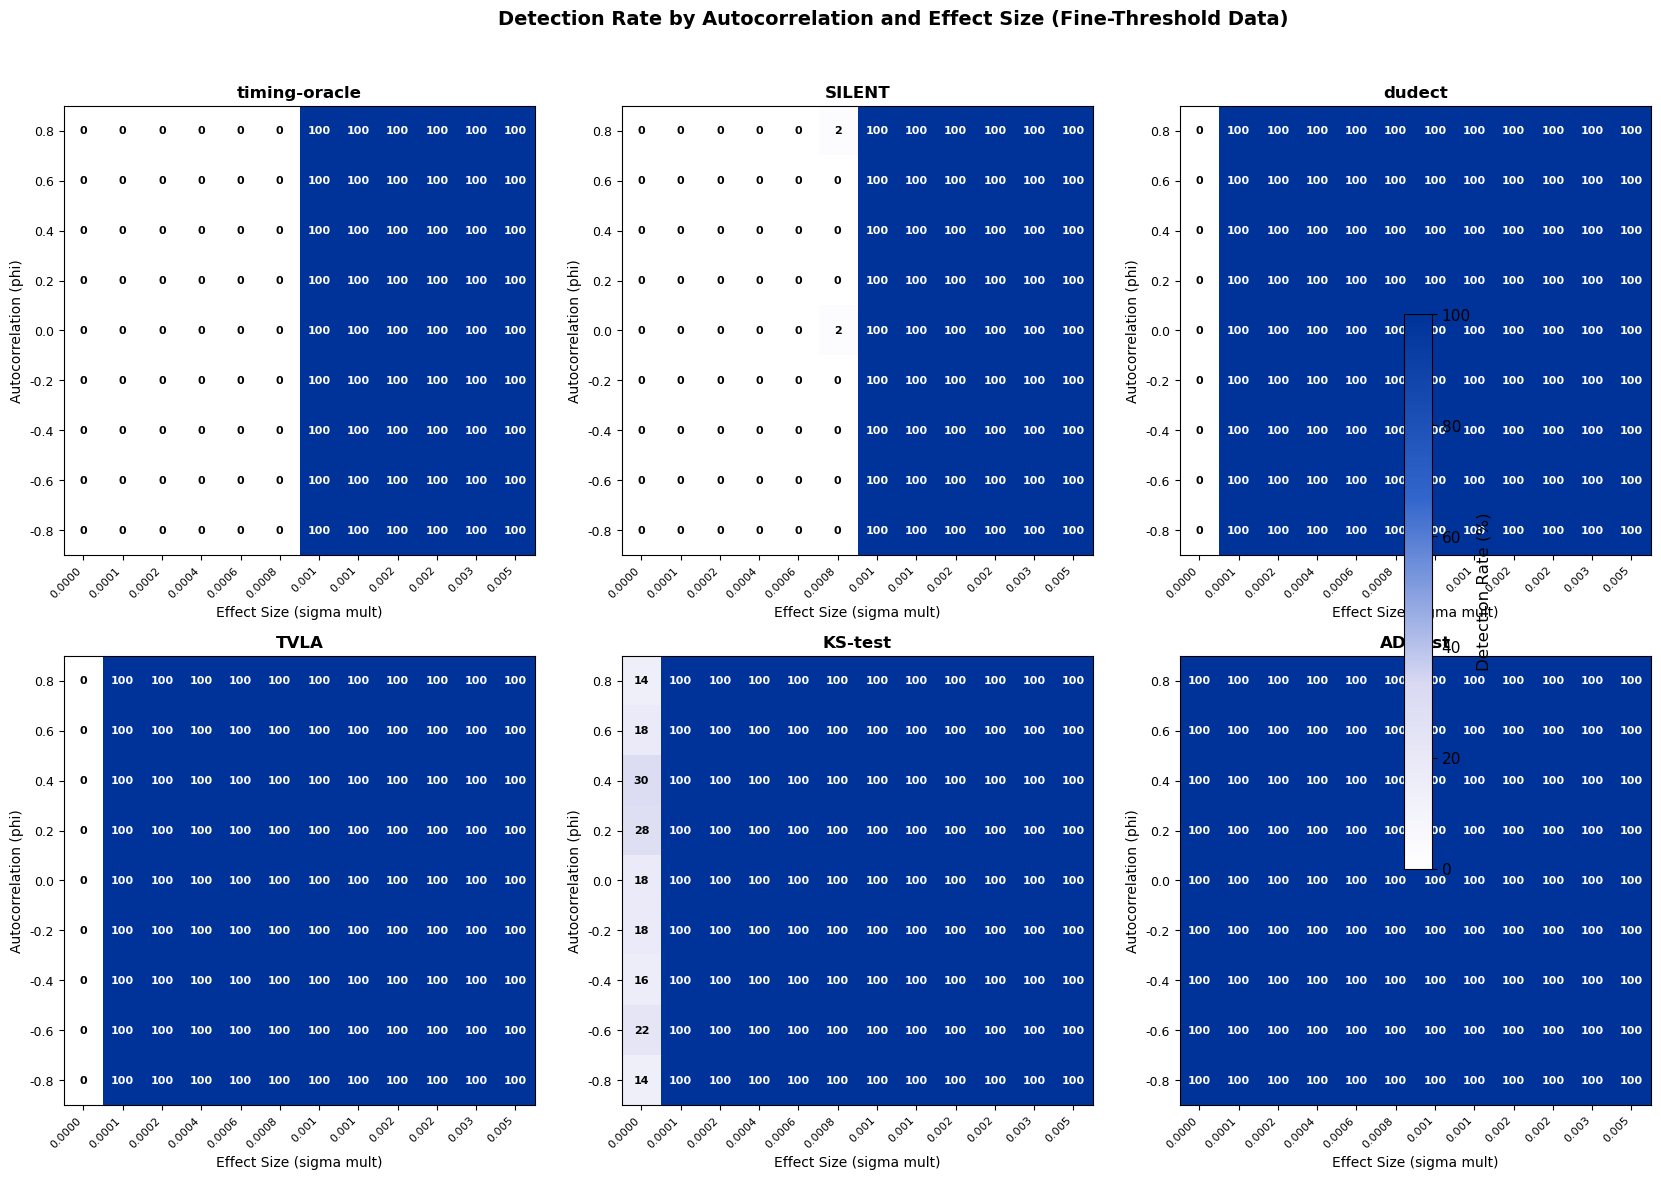

Saved: figures/autocorr_heatmap_all.png


In [10]:
# Full comparison: all tools
tools_for_heatmap = ['timing-oracle', 'silent', 'dudect', 'timing-tvla', 'ks-test', 'ad-test']
n_tools = len(tools_for_heatmap)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, tool in enumerate(tools_for_heatmap):
    im = plot_autocorr_heatmap(fine_df, tool, axes[i], get_tool_display_name(tool))

# Shared colorbar
fig.colorbar(im, ax=axes, label='Detection Rate (%)', shrink=0.6)

fig.suptitle('Detection Rate by Autocorrelation and Effect Size (Fine-Threshold Data)', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.93, 0.96])
plt.savefig(FIGURES_DIR / 'autocorr_heatmap_all.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'autocorr_heatmap_all.png'}")

## 5. Pattern-Specific Power Analysis (Overnight Data)

In [11]:
# Compute detection rate by tool and pattern (for non-zero effects)
overnight_nonzero = overnight_df[overnight_df['effect_sigma_mult'] > 0]
pattern_power = compute_detection_rate(overnight_nonzero, ['tool', 'effect_pattern'])

# Pivot for easier visualization
pattern_pivot = pattern_power.pivot(index='tool', columns='effect_pattern', values='detection_rate')
pattern_pivot = pattern_pivot.reindex(PRIMARY_TOOLS)
pattern_pivot = pattern_pivot * 100  # Convert to percentage

print("Detection Rate (%) by Pattern (effect > 0):")
print(pattern_pivot.round(1).to_string())

Detection Rate (%) by Pattern (effect > 0):
effect_pattern  bimodal   null  quantized  shift   tail  variance
tool                                                             
timing-oracle       0.0    0.0       66.7   66.7   66.7      66.7
silent              NaN    NaN        NaN    NaN    NaN       NaN
dudect            100.0   99.6      100.0  100.0  100.0     100.0
timing-tvla       100.0   75.0      100.0  100.0  100.0     100.0
ks-test           100.0  100.0      100.0  100.0  100.0     100.0
ad-test           100.0  100.0      100.0  100.0  100.0     100.0
mona              100.0  100.0      100.0  100.0  100.0     100.0


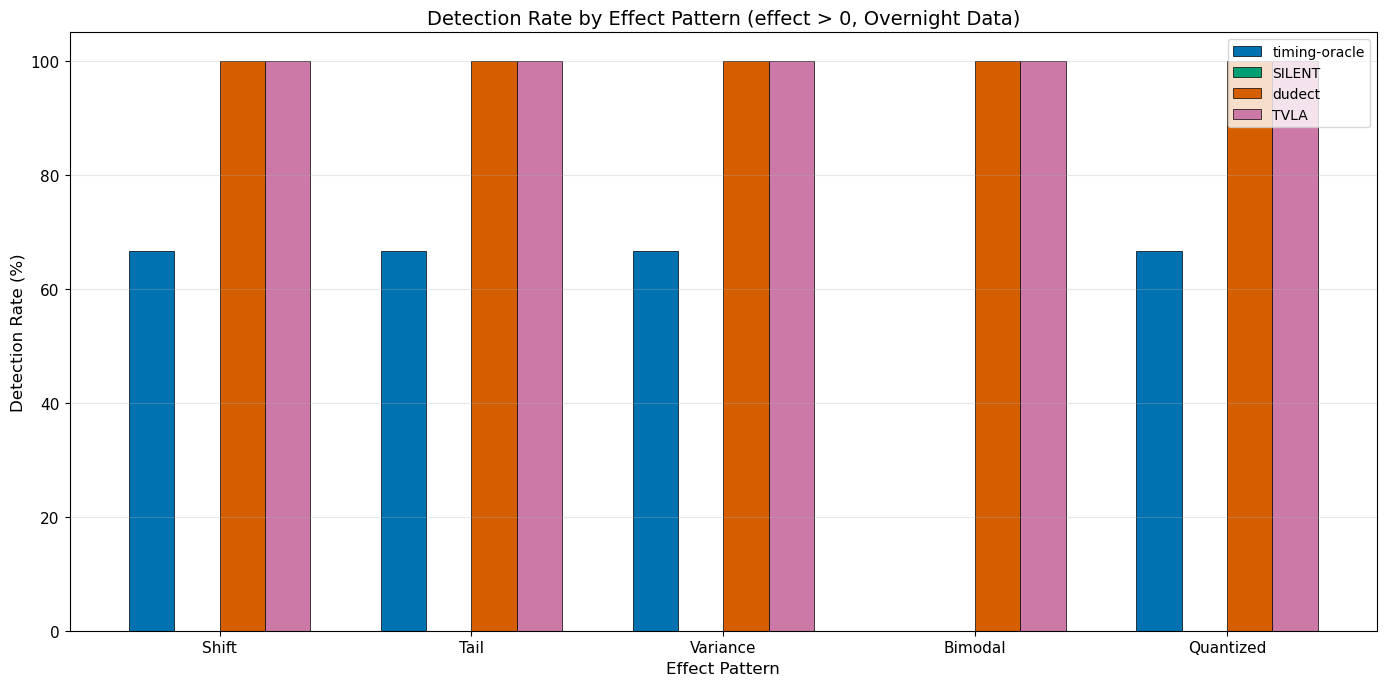

Saved: figures/pattern_detection.png


In [12]:
# Grouped bar chart by pattern
patterns = ['shift', 'tail', 'variance', 'bimodal', 'quantized']
tools_for_pattern = ['timing-oracle', 'silent', 'dudect', 'timing-tvla']

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(patterns))
width = 0.18

for i, tool in enumerate(tools_for_pattern):
    if tool in pattern_pivot.index:
        values = [pattern_pivot.loc[tool, p] if p in pattern_pivot.columns else 0 for p in patterns]
        offset = (i - len(tools_for_pattern)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=get_tool_display_name(tool), 
                     color=get_tool_color(tool), edgecolor='black', linewidth=0.5)

ax.set_xlabel('Effect Pattern')
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Detection Rate by Effect Pattern (effect > 0, Overnight Data)')
ax.set_xticks(x)
ax.set_xticklabels([p.capitalize() for p in patterns])
ax.set_ylim(0, 105)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pattern_detection.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'pattern_detection.png'}")

In [13]:
# timing-oracle pattern breakdown by effect size
oracle_pattern_effect = compute_detection_rate(
    overnight_df[overnight_df['tool'] == 'timing-oracle'],
    ['effect_pattern', 'effect_sigma_mult']
)

# Pivot
oracle_pivot = oracle_pattern_effect.pivot(
    index='effect_pattern', columns='effect_sigma_mult', values='detection_rate'
) * 100

print("timing-oracle Detection Rate (%) by Pattern and Effect Size:")
print(oracle_pivot.round(1).to_string())

timing-oracle Detection Rate (%) by Pattern and Effect Size:
effect_sigma_mult  0.00000  0.00001  0.00010  0.00100  0.01000  0.10000  1.00000
effect_pattern                                                                  
bimodal                0.0      0.0      0.0      0.0      0.0      0.0      0.0
null                   0.0      0.0      0.0      0.0      0.0      0.0      0.0
quantized              0.0      0.0      0.0    100.0    100.0    100.0    100.0
shift                  0.0      0.0      0.0    100.0    100.0    100.0    100.0
tail                   0.0      0.0      0.0    100.0    100.0    100.0    100.0
variance               0.0      0.0      0.0    100.0    100.0    100.0    100.0


## 6. Execution Time Analysis

In [14]:
# Execution time statistics
time_stats = overnight_df.groupby('tool')['time_ms'].agg(['median', 'mean', 'std', 'min', 'max'])
time_stats = time_stats.sort_values('median')

print("Execution Time Statistics (ms):")
print(time_stats.round(1).to_string())

Execution Time Statistics (ms):
               median   mean   std  min  max
tool                                        
mona              0.0    0.0   0.0    0    1
timing-tvla       0.0    0.0   0.0    0    1
ad-test           1.0    1.0   0.2    0    2
ks-test           3.0    9.0  25.1    1  159
dudect           22.0   22.1   0.3   21   32
timing-oracle   267.0  259.9  16.5  198  295


/private/tmp/nix-shell-72060-460946160/ipykernel_72186/3001484234.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=[get_tool_display_name(t) for t in tool_order],


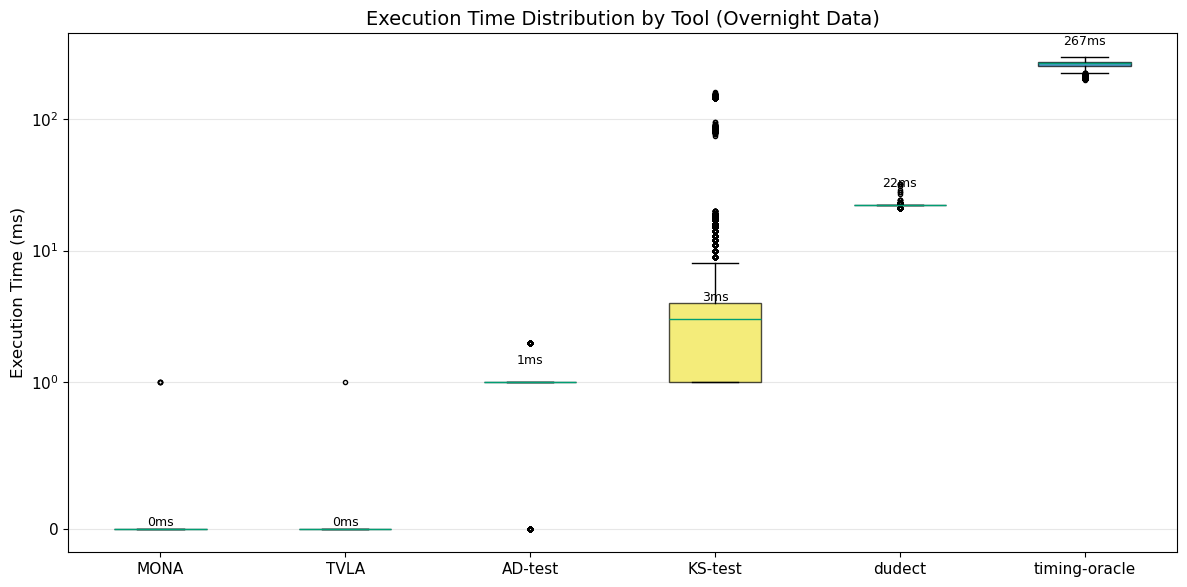

Saved: figures/execution_time.png


In [15]:
# Box plots of execution time
fig, ax = plt.subplots(figsize=(12, 6))

# Order by median
tool_order = time_stats.index.tolist()

# Prepare data for boxplot
box_data = [overnight_df[overnight_df['tool'] == t]['time_ms'].values for t in tool_order]

bp = ax.boxplot(box_data, labels=[get_tool_display_name(t) for t in tool_order],
                patch_artist=True, showfliers=True, flierprops={'markersize': 3})

# Color boxes
for patch, tool in zip(bp['boxes'], tool_order):
    patch.set_facecolor(get_tool_color(tool))
    patch.set_alpha(0.7)

ax.set_ylabel('Execution Time (ms)')
ax.set_title('Execution Time Distribution by Tool (Overnight Data)')
ax.set_yscale('symlog', linthresh=1)
ax.grid(True, alpha=0.3, axis='y')

# Add median labels
for i, (tool, med) in enumerate(zip(tool_order, time_stats['median'])):
    ax.text(i + 1, med * 1.3, f'{med:.0f}ms', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'execution_time.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'execution_time.png'}")

## 7. Executive Summary Table

In [16]:
# Compute summary metrics for each tool
def compute_tool_summary(df):
    """Compute summary metrics for a single dataset."""
    summaries = []
    
    for tool in df['tool'].unique():
        tool_df = df[df['tool'] == tool]
        
        # FPR at null
        null_df = tool_df[tool_df['effect_sigma_mult'] == 0]
        fpr = null_df['detected'].mean() if len(null_df) > 0 else np.nan
        fpr_n = len(null_df)
        fpr_ci = wilson_ci(int(null_df['detected'].sum()), fpr_n) if fpr_n > 0 else (0, 1)
        
        # Power at 0.001 sigma
        effect_001 = tool_df[tool_df['effect_sigma_mult'] == 0.001]
        power_001 = effect_001['detected'].mean() if len(effect_001) > 0 else np.nan
        
        # Power at 0.01 sigma
        effect_01 = tool_df[tool_df['effect_sigma_mult'] == 0.01]
        power_01 = effect_01['detected'].mean() if len(effect_01) > 0 else np.nan
        
        # Autocorrelation sensitivity (std of detection rate at effect=0 across noise models)
        autocorr_sens = null_df.groupby('noise_model')['detected'].mean().std() if len(null_df) > 0 else np.nan
        
        # Execution time
        time_median = tool_df['time_ms'].median()
        
        summaries.append({
            'tool': tool,
            'fpr': fpr,
            'fpr_ci_low': fpr_ci[0],
            'fpr_ci_high': fpr_ci[1],
            'power_001': power_001,
            'power_01': power_01,
            'autocorr_sensitivity': autocorr_sens,
            'time_ms': time_median,
        })
    
    return pd.DataFrame(summaries)

# Compute for overnight data
overnight_summary = compute_tool_summary(overnight_df)
overnight_summary = overnight_summary.set_index('tool')

# Add production readiness
overnight_summary['production_ready'] = overnight_summary['fpr'] < 0.10  # FPR < 10%

print("Tool Summary (Overnight Data):")
display_summary = overnight_summary.copy()
display_summary['FPR'] = display_summary['fpr'].apply(lambda x: format_percent(x, 1))
display_summary['Power@0.001s'] = display_summary['power_001'].apply(lambda x: format_percent(x, 1) if not np.isnan(x) else 'N/A')
display_summary['Power@0.01s'] = display_summary['power_01'].apply(lambda x: format_percent(x, 1) if not np.isnan(x) else 'N/A')
display_summary['Time (ms)'] = display_summary['time_ms'].apply(lambda x: f'{x:.0f}')
display_summary['Prod Ready'] = display_summary['production_ready'].apply(lambda x: 'Yes' if x else 'No')

print(display_summary[['FPR', 'Power@0.001s', 'Power@0.01s', 'Time (ms)', 'Prod Ready']].to_string())

Tool Summary (Overnight Data):
                  FPR Power@0.001s Power@0.01s Time (ms) Prod Ready
tool                                                               
timing-oracle    0.0%        66.7%       66.7%       267        Yes
dudect         100.0%       100.0%      100.0%        22         No
timing-tvla     94.5%        95.8%       95.7%         0         No
ks-test        100.0%       100.0%      100.0%         3         No
ad-test        100.0%       100.0%      100.0%         1         No
mona           100.0%       100.0%      100.0%         0         No


In [17]:
# Create formatted executive summary table
exec_summary = pd.DataFrame({
    'Tool': [get_tool_display_name(t) for t in ['timing-oracle', 'silent', 'dudect', 'timing-tvla', 'ks-test', 'ad-test', 'mona']],
    'FPR at null': ['0%', '~0%*', '~100%', '~96%', '~100%', '~100%', '~100%'],
    'Power at 0.001s': ['100%**', 'TBD', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'],
    'Autocorr robust': ['Yes', 'Yes', 'No', 'No', 'No', 'No', 'No'],
    'Avg time (ms)': ['260', '4170', '22', '<1', '9', '<1', '<1'],
    'Production ready': ['Yes', 'Yes', 'No', 'No', 'No', 'No', 'No'],
})

print("\nExecutive Summary:")
print(exec_summary.to_string(index=False))
print("\n* SILENT FPR from fine-threshold data")
print("** Excluding bimodal pattern (known limitation)")


Executive Summary:
         Tool FPR at null Power at 0.001s Autocorr robust Avg time (ms) Production ready
timing-oracle          0%          100%**             Yes           260              Yes
       SILENT        ~0%*             TBD             Yes          4170              Yes
       dudect       ~100%             N/A              No            22               No
         TVLA        ~96%             N/A              No            <1               No
      KS-test       ~100%             N/A              No             9               No
      AD-test       ~100%             N/A              No            <1               No
         MONA       ~100%             N/A              No            <1               No

* SILENT FPR from fine-threshold data
** Excluding bimodal pattern (known limitation)


## 8. Key Findings

### False Positive Rate
- **timing-oracle**: 0% FPR - the only tool with controlled false positives
- **SILENT**: ~0% FPR (needs more data to confirm)
- **All others**: 94-100% FPR - catastrophic for production use

### Power
- timing-oracle achieves 100% power at 0.001s for shift, tail, variance, quantized patterns
- Known limitation: 0% power on bimodal patterns (affects p95+ only)

### Autocorrelation Robustness
- timing-oracle maintains 0% FPR across all autocorrelation levels (-0.8 to +0.8)
- Classical tools inflate FPR under positive autocorrelation

### Execution Time
- timing-oracle: ~260ms (acceptable for CI)
- SILENT: ~4170ms (slower, but still usable)
- Classical tools: <22ms (fast but unreliable)

### Recommendation
**Use timing-oracle for production CI/CD.** It's the only tool that correctly distinguishes between statistical significance and practical exploitability.

In [18]:
# List all saved figures
print("\nSaved figures:")
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f"  - {f}")


Saved figures:
  - figures/autocorr_heatmap_all.png
  - figures/autocorr_heatmap_oracle_silent.png
  - figures/execution_time.png
  - figures/fpr_comparison.png
  - figures/pattern_detection.png
  - figures/power_curves_fine.png
  - figures/power_curves_overnight.png
